# main function


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  4 16:56:55 2021
Ai for Alpha
Copyright Thu Aug  2021
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

'''
compute strategy returns from weights
- inputs returns, weights
'''
def portfolio_returns(df, weights, cost, isReturns=True):
    returns = df if isReturns else df.pct_change().fillna(0) 
    day_lag = 1
    if returns.shape[0] > weights.shape[0]:
        returns = returns.loc[weights.index]
    if  type(returns) == pd.core.series.Series:
        returns = returns.to_frame()
    strategyReturn = returns * weights.shift(1 + day_lag)
    dfPreviousWeights = weights.shift(1)
    transactionCost = (weights-dfPreviousWeights).mul(cost,axis=1).abs()
    netStrategyReturns=strategyReturn-transactionCost
    return netStrategyReturns

'''
compute past volatility to resize accordingly
'''
def apply_volTargetting(df, weights, volTarget, period = 60, max_leverage=5, isReturns=True):
    returns = df if isReturns else df.pct_change().fillna(0) 
    factor = 250 ** 0.5
    extendedScore = np.vstack([np.tile(weights.iloc[0,:].values, period).reshape(period, weights.shape[1]), weights])
    startIndex = np.where(returns.index <= weights.index[0])[0][-1]-period
    endIndex = startIndex + extendedScore.shape[0]+1
    returns = returns.iloc[startIndex:endIndex]
    computations = np.dot(returns, np.transpose(extendedScore))
    initialVols = np.zeros(weights.shape[0])
    for i in range(weights.shape[0]):
        initialVols[i] = np.std(computations[i:i+period,(i+period-1)]) * factor 
    if len(np.where(initialVols == 0)[0])> 0:
        print('failed to do volTargetting, there are zero! Found problem at dates=', end= ' ')
        print(df.index[np.where(initialVols == 0)[0]])
        return weights, False
    else:
        newLeverage = volTarget / initialVols
        if newLeverage.max() > max_leverage:
            print('check weights as max leverage={:.2f}'.format(newLeverage.max()))
        weights = weights.multiply(newLeverage, axis=0)
        return weights, True

'''
compute strategy

'''
def compute_strategy(df, weights, cost, volTarget = 0, bPlot=False, 
        isReturns=True, return_only_strategy=True):
    returns = df if isReturns else df.pct_change().fillna(0) 
    if volTarget > 0:
        weights, success = apply_volTargetting(returns, weights, volTarget)
        if not success:
            print('failed to compute strategy')
            return (1 + 0 * returns.iloc[:,0])
    strat_returns = portfolio_returns(returns, weights, cost)
    strategy = (1 + strat_returns.sum(axis=1).fillna(0)).cumprod()
    if bPlot:
        strategy.plot()
    if return_only_strategy:
        return strategy 
    else:
        return (strategy, strat_returns, weights)


'''
generic function to read data
'''

def read_data(filename):
    df = pd.read_csv(f'..//data//{filename}', index_col=0)
    df = df / df.iloc[0]
    df.index = pd.to_datetime(df.index, dayfirst=True)
    return df


# read data

In [2]:
prices = read_data('strategies.csv')
test_date = '2007-01-01'
end_date = None
dfWeights = pd.read_csv('..//data//weights.csv', index_col=0)
dfWeights.index = pd.to_datetime(dfWeights.index)
cost = 0.0005
volTarget = 0.05
# do voltargetting
track_record, strat_returns, weights = compute_strategy(prices, dfWeights, cost, 
        volTarget = volTarget, bPlot=False, isReturns=False, return_only_strategy=False)
track_record.name = 'AI for Alpha'

df_benchmark = read_data('benchmark.csv')
df_benchmark = df_benchmark.reindex(track_record.index).fillna(method='ffill').fillna(method='bfill')
df_benchmark = df_benchmark/df_benchmark.iloc[0]
df_benchmark.columns = ['Benchmark']

total_df = pd.concat([track_record, df_benchmark], axis=1)

# plot

NameError: name 'plt' is not defined

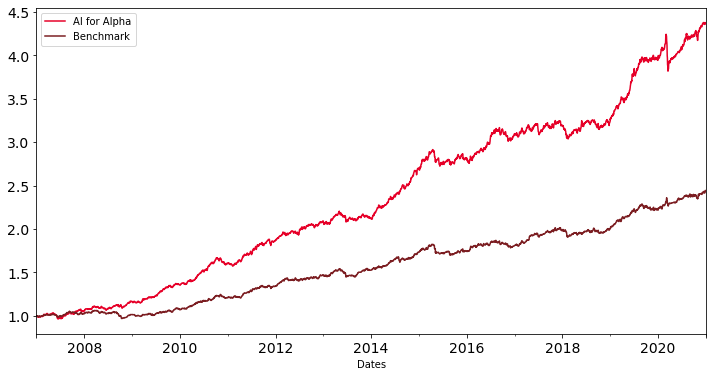

In [4]:
SGColors = {'SG_Beige': "#D6C292",
                'SG_Black': "#17202A",
                'SG_Brown': "#7B1D21",
                'SG_Brown2': "#A66B02",
                'SG_DarkBeige': "#BD9C4F",
                'SG_DarkGrey': "#212F3D",
                'SG_Green': "#2D575B",
                'SG_Grey': "#C1BCBC",
                'SG_Grey2': "#938A8A",
                'SG_LightTeal': "#B8D8DC",
                'SG_MidGrey': "#566573",
                'SG_Red': "#E60028",
                'SG_Red2': "#D65258",
                'SG_Teal': "#519BA5",
                'SG_Tomato': "#E38A8E",
                'SG_LightGrey': "#D3D3D3"}    
total_df.plot(figsize=(12,6), color =[SGColors['SG_Red'], 
            SGColors['SG_Brown']],
    fontsize=14,)
plt.show()

print('last values')
print(total_df.iloc[-1])
